<a href="https://colab.research.google.com/github/YouMinJung/Zombie_Detector/blob/main/Zombie_Detector_With_RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Zombie Detector

Detect the zombie in some images. I will use the Object Detection API and retain [RetinaNet](https://arxiv.org/abs/1708.02002) to spot zombies using 5 training images.

### Installation

Installing Tessorflow 2 [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection)

In [1]:
# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

# Compile the Object Detection API protocol buffers
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=.

Cloning into 'models'...
remote: Enumerating objects: 3399, done.
remote: Counting objects: 100% (3399/3399), done.
remote: Compressing objects: 100% (2826/2826), done.
remote: Total 3399 (delta 895), reused 1401 (delta 516), pack-reused 0
Receiving objects: 100% (3399/3399), 34.95 MiB | 33.36 MiB/s, done.
Resolving deltas: 100% (895/895), done.


In [2]:
%%writefile models/research/setup.py

import os
from setuptools import find_packages
from setuptools import setup

REQUIRED_PACKAGES = [
    'tf-models-official==2.8.0',
    'tensorflow_io'
]

setup(
    name='object_detection',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    include_package_data=True,
    packages=(
        [p for p in find_packages() if p.startswith('object_detection')] +
        find_packages(where=os.path.join('.', 'slim'))),
    package_dir={
        'datasets': os.path.join('slim', 'datasets'),
        'nets': os.path.join('slim', 'nets'),
        'preprocessing': os.path.join('slim', 'preprocessing'),
        'deployment': os.path.join('slim', 'deployment'),
        'scripts': os.path.join('slim', 'scripts'),
    },
    description='Tensorflow Object Detection Library',
    python_requires='>3.6',
)

Writing models/research/setup.py


In [3]:
# Run the setup script you just wrote
!python -m pip install models/research

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 2.2 MB 25.4 MB/s 
     |████████████████████████████████| 25.9 MB 1.3 MB/s 
     |████████████████████████████████| 1.1 MB 56.3 MB/s 
     |████████████████████████████████| 636 kB 63.6 MB/s 
     |████████████████████████████████| 237 kB 59.0 MB/s 
     |████████████████████████████████| 92 kB 14.5 MB/s 
     |████████████████████████████████| 1.2 MB 64.6 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |█████████

### Imports

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# import the label map utility module
from object_detection.utils import label_map_util

# import module for reading and updating configuration files.
from object_detection.utils import config_util

# import module for visualization. use the alias `viz_utils`
from object_detection.utils import visualization_utils as viz_utils

# import module for building the detection model
from object_detection.builders import model_builder
### END CODE HERE ###

# import module for utilities in Colab
from object_detection.utils import colab_utils

### Utilities

In [5]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)

### Download the Zombie data

* The zombies are hosted in a Google bucket.
* unzip the images into a local `training/` directory.

In [6]:
# download the images
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training-zombie.zip \
    -O ./training-zombie.zip

# unzip to a local directory
local_zip = './training-zombie.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

--2022-06-28 06:18:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training-zombie.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.80, 172.253.62.128, 142.251.33.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915446 (1.8M) [application/zip]
Saving to: ‘./training-zombie.zip’

./training-zombie.z 100%[===================>]   1.83M  --.-KB/s    in 0.01s   

2022-06-28 06:18:01 (144 MB/s) - ‘./training-zombie.zip’ saved [1915446/1915446]



### Visualize the training images

./training/training-zombie1.jpg
./training/training-zombie2.jpg
./training/training-zombie3.jpg
./training/training-zombie4.jpg
./training/training-zombie5.jpg


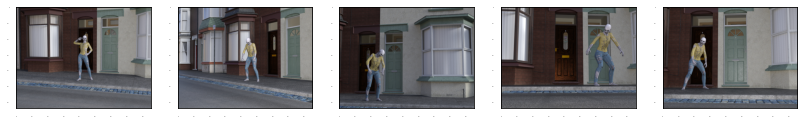

In [7]:
%matplotlib inline

# assign the name (string) of the directory containing the training images
train_image_dir = './training'

# declare an empty list
train_images_np = []

# run a for loop for each image
for i in range(1, 6):

    # define the path (string) for each image
    image_path = os.path.join(train_image_dir + "/training-zombie" + str(i) + ".jpg")
    print(image_path)

    # load images into numpy arrays and append to a list
    train_images_np.append(load_image_into_numpy_array(image_path))

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()

### Prepare data for training

* Draw a box around the zombie in each image. 
* Click the `next image` button to go to the next image
* Click `submit` when it says "All images completed!!". 

- Make sure to not make the bounding box too big. 
  - If the box is too big, the model might learn the features of the background (e.g. door, road, etc) in determining if there is a zombie or not. 
- Include the entire zombie inside the box. 
- As an example, scroll to the beginning of this notebook to look at the bounding box around the zombie.

In [8]:
# Define the list of ground truth boxes
gt_boxes = []

# annotate the training images
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [9]:
# TEST CODE:
try:
  assert(len(gt_boxes) == 5), "Warning: gt_boxes is empty. Did you click `submit`?"

except AssertionError as e:
  print(e)

# checks if there are boxes for all 5 images
for gt_box in gt_boxes:
    try:
      assert(gt_box is not None), "There are less than 5 sets of box coordinates. " \
                                  "Please re-run the cell above to draw the boxes again.\n" \
                                  "Alternatively, you can run the next cell to load pre-determined " \
                                  "ground truth boxes."
    
    except AssertionError as e:
        print(e)
        break


ref_gt_boxes = [
        np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
        np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
        np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
        np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
        np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
      ]

for gt_box, ref_gt_box in zip(gt_boxes, ref_gt_boxes):
    try:
      assert(np.allclose(gt_box, ref_gt_box, atol=0.04)), "One of the boxes is too big or too small. " \
                                                          "Please re-draw and make the box tighter around the zombie."
    
    except AssertionError as e:
      print(e)
      break

### View ground truth box coordinates

In [10]:
# print the coordinates of your ground truth boxes
for gt_box in gt_boxes:
  print(gt_box)

[[0.27773437 0.41617819 0.73940104 0.58382181]]
[[0.29940104 0.46072685 0.75106771 0.60961313]]
[[0.41440104 0.18053927 0.93940104 0.34818288]]
[[0.16440104 0.62133646 0.79440104 0.9144197 ]]
[[0.29606771 0.12895662 0.82940104 0.34935522]]


### Define the category index dictionary

- **zombie_class_id**: By convention, class ID integers start numbering from 1,2,3, onward. If there is ever a 'background' class, it could be assigned the integer 0, but in this case, I'm just predicting the one zombie class (just predicting one class (zombie)) so zombie class ID = 1.

- **category_index**: Define `category_index` similar to the example dictionary above, except for zombies. This will be used by the succeeding functions to know the class `id` and `name` of zombie images.

- **num_classes**: This will be used during data preprocessing and again when you configure the model.

In [11]:
# Assign the zombie class ID
zombie_class_id = 1

# define a dictionary describing the zombie class
category_index = {
    zombie_class_id :
    {
        'id' : zombie_class_id,
        'name' : 'zombie'
    }
}

# Specify the number of classes that the model will predict
num_classes = 1

# TEST CODE :
print(category_index[zombie_class_id])

{'id': 1, 'name': 'zombie'}


### Data preprocessing

- Convert the class labels to one-hot representations
- convert everything (i.e. train images, gt boxes and class labels) to tensors.

In [12]:
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.

label_id_offset = 1
train_image_tensors = []

# lists containing the one-hot encoded classes and ground truth boxes
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    
    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
    
    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    
    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    
    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')

Done prepping data.


### Visualize the zombie with their ground truth bounding boxes

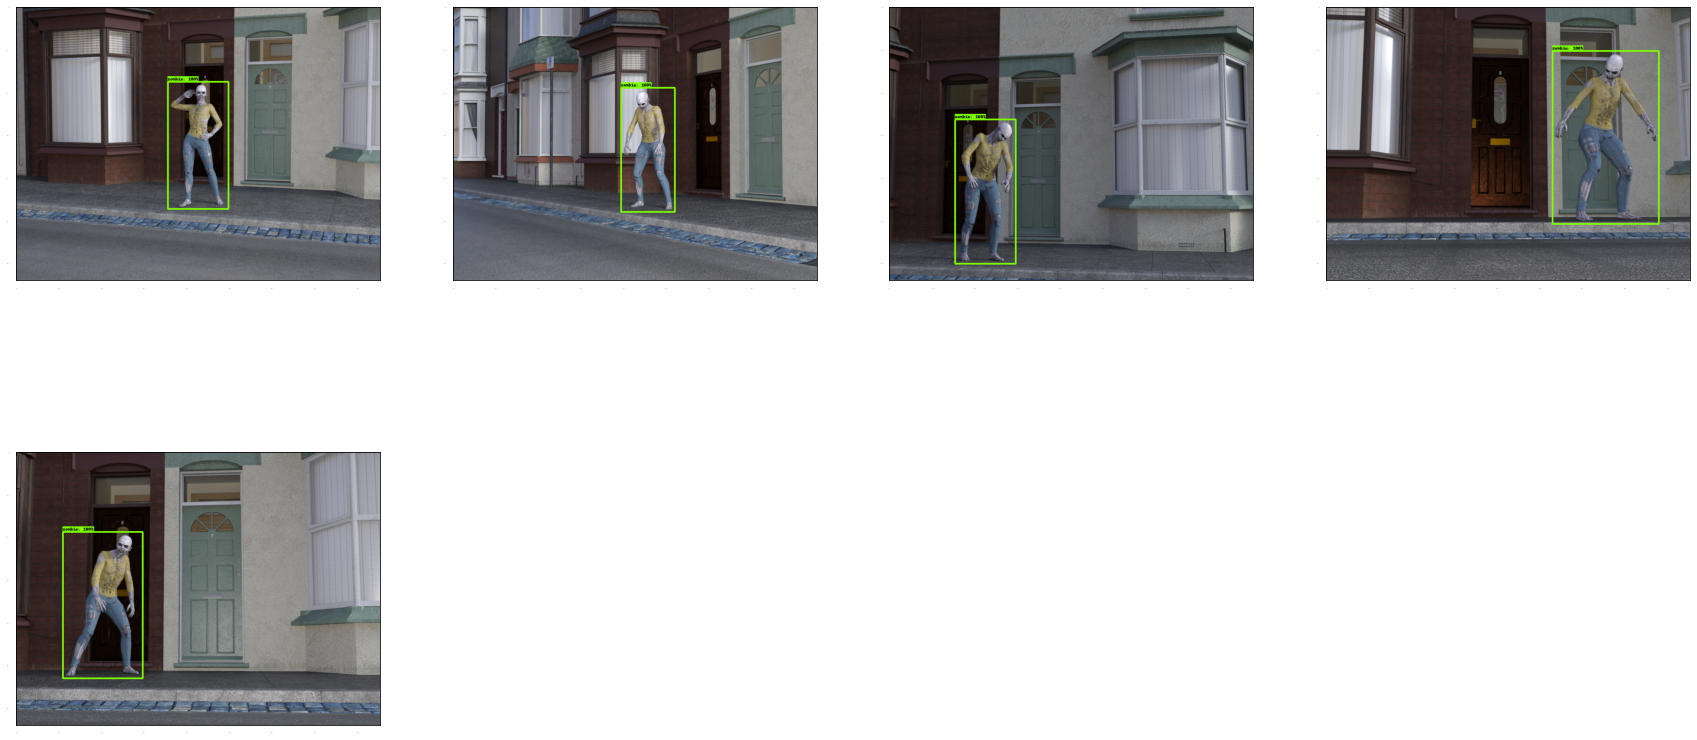

In [13]:
# give boxes a score of 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(30, 15))

# use the `plot_detections()` utility function to draw the ground truth boxes
for idx in range(5):
    plt.subplot(2, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

### Download the checkpoint containing the pre-trained weights

- Download the compressed SSD Resnet 50 version 1, 640 x 640 checkpoint.
- Untar (decompress) the tar file
- Move the decompressed checkpoint to `models/research/object_detection/test_data/`

<a href="https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md">TensorFlow 2 Detection Model Zoo<a>

In [14]:
# Download the SSD Resnet 50 version 1, 640x640 checkpoint
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# untar (decompress) the tar file
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

# copy the checkpoint to the test_data folder models/research/object_detection/test_data/
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-06-28 06:19:35--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.33.208, 2607:f8b0:4004:c19::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.33.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   236MB/s    in 1.0s    

2022-06-28 06:19:36 (236 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



### Configure the model

### Locate and read from the configuration file

In [15]:
tf.keras.backend.clear_session()

# define the path to the .config file for ssd resnet 50 v1 640x640
pipeline_config = "/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"

# Load the configuration file into a dictionary
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

# See what configs looks like
configs

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
   

### Get the model configuration

#### model_config
- From the `configs` dictionary, access the object associated with the key 'model'.
- `model_config` now contains an object of type `object_detection.protos.model_pb2.DetectionModel`. 

In [16]:
# Read in the object stored at the key 'model' of the configs dictionary
model_config = configs['model']
# model_config = configs.get('model')

### END CODE HERE
# see what model_config looks like
model_config

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: f

### Modify model_config
Modify num_classes from the default `90` to `1`.
Freeze batch normalization by setting the relevant field to `True`.

In [17]:
# Modify the number of classes from its default of 90
model_config.ssd.num_classes = 1

# Freeze batch normalization
model_config.ssd.freeze_batchnorm = True

# See what model_config now looks like after you've customized it!
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

### Build the model using model_builder

In [18]:
detection_model = model_builder.build(model_config=model_config, is_training=True)

print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


### Restore weights from own checkpoint

* I will reuse only `Feature extraction layers` and `Bounding box regression prediction layer`.
* The part of RetinaNet that I will not want to reuse is the classification prediction layer (since I will define and train own classification layer specific to zombies).
* For the parts of RetinaNet that I want to reuse, I will also restore the weights from the checkpoint that I selected.

### Define checkpoints for desired layers

I will now isolate the layers of `detection_model` that I wish to reuse so that I can restore the weights to just those layers.

* First, define checkpoints for the box predictor
* Next, define checkpoints for the model, which will point to this box predictor checkpoint as well as the feature extraction layers.

In [19]:
tmp_box_predictor_checkpoint = tf.train.Checkpoint(
  _base_tower_layers_for_heads = detection_model._box_predictor._base_tower_layers_for_heads,
  _box_prediction_head = detection_model._box_predictor._box_prediction_head
)

# Check the datatype of this checkpoint
type(tmp_box_predictor_checkpoint) # tensorflow.python.training.tracking.util.Checkpoint

# Check the variables of this checkpoint
vars(tmp_box_predictor_checkpoint)

{'_attached_dependencies': None,
 '_base_tower_layers_for_heads': DictWrapper({'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
 '_box_prediction_head': <object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead at 0x7fa80f849590>,
 '_save_assign_op': None,
 '_save_counter': None,
 '_saver': <tensorflow.python.training.tracking.util.TrackableSaver at 0x7fa80f6983d0>,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_base_tower_layers_for_heads, ref={'box_encodings': ListWrapper([]), 'class_predictions_with_background': ListWrapper([])}),
  TrackableReference(name=_box_prediction_head, ref=<object_detection.predictors.heads.keras_box_head.WeightSharedConvolutionalBoxHead object at 0x7fa80f849590>)],
 '_self_unconditional_deferred_dependencies': {},
 '_self_unconditional_dependency_names': {'

### Define the temporary model checkpoint**

Define `tmp_model_checkpoint` so that it points to these two layers:
* The feature extractor of the detection model.
* The temporary box predictor checkpoint that you just defined.

In [20]:
tmp_model_checkpoint = tf.train.Checkpoint(
  _box_predictor = tmp_box_predictor_checkpoint,
  _feature_extractor = detection_model._feature_extractor
)

# Check the datatype of this checkpoint
type(tmp_model_checkpoint) # tensorflow.python.training.tracking.util.Checkpoint

# Check the vars of this checkpoint
vars(tmp_model_checkpoint)

{'_attached_dependencies': None,
 '_box_predictor': <tensorflow.python.training.tracking.util.Checkpoint at 0x7fa80f698250>,
 '_feature_extractor': <object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor at 0x7fa812256910>,
 '_save_assign_op': None,
 '_save_counter': None,
 '_saver': <tensorflow.python.training.tracking.util.TrackableSaver at 0x7fa80f698990>,
 '_self_name_based_restores': set(),
 '_self_saveable_object_factories': {},
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [TrackableReference(name=_box_predictor, ref=<tensorflow.python.training.tracking.util.Checkpoint object at 0x7fa80f698250>),
  TrackableReference(name=_feature_extractor, ref=<object_detection.models.ssd_resnet_v1_fpn_keras_feature_extractor.SSDResNet50V1FpnKerasFeatureExtractor object at 0x7fa812256910>)],
 '_self_unconditional_deferred_dependencies': {},
 '_self_unconditional_dependency_names': {'_box_predictor': <tensorflow

### Restore the checkpoint

In [21]:
checkpoint_path = '/content/models/research/object_detection/test_data/checkpoint/ckpt-0'

# Define a checkpoint that sets `model= None
checkpoint = tf.train.Checkpoint(model=tmp_model_checkpoint)

# Restore the checkpoint to the checkpoint path
checkpoint.restore(checkpoint_path)

### Run a dummy image to generate the model variables

Recall that `detection_model` is an object of type [object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch]() 

Important methods that are available in the `detection_model` object  are:
- [preprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L459): 
    - takes in a tensor representing an image and returns
    - returns `image, shapes`
    - For the dummy image, you can declare a [tensor of zeros](https://www.tensorflow.org/api_docs/python/tf/zeros) that has a shape that the `preprocess()` method can accept (i.e. [batch, height, width, channels]). 
    - Remember that your images have dimensions 640 x 640 x 3. 
    - You can pass in a batch of 1 when making the dummy image. 

- [predict()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L525)
  - takes in `image, shapes` which are created by the `preprocess()` function call.
  - returns a prediction in a Python dictionary
  - this will pass the dummy image through the forward pass of the network and create the model variables

- [postprocess()](https://github.com/tensorflow/models/blob/dc4d11216b738920ddb136729e3ae71bddb75c7e/research/object_detection/meta_architectures/ssd_meta_arch.py#L655)
  - Takes in the prediction_dict and shapes
  - returns a dictionary of post-processed predictions of detected objects ("detections").

In [30]:
# use the detection model's `preprocess()` method and pass a dummy image
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))

# run a prediction with the preprocessed image and shapes
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)

# postprocess the predictions into final detections
tmp_detections = detection_model.postprocess(tmp_prediction_dict, tmp_shapes)

# Test Code:
assert len(detection_model.trainable_variables) > 0, "Please pass in a dummy image to create the trainable variables."
print(detection_model.weights[0].shape)
print(detection_model.weights[231].shape)
print(detection_model.weights[462].shape)

(3, 3, 256, 24)
(512,)
(256,)


### Define the training step

- Preprocess the images
- Make a prediction
- Calculate the loss (and make sure the loss function has the ground truth to compare with the prediction)
- Calculate the total loss:
  - `total_loss` = `localization_loss + classification_loss`
- Calculate gradients with respect to the variables you selected to train.
- Optimize the model's variables

In [31]:
# decorate with @tf.function for faster training (remember, graph mode!)
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):
    """A single training iteration.

    Args:
      image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """

    with tf.GradientTape() as tape:

        # Preprocess the images
        preprocessed_image_list = []
        true_shape_list = []

        model.provide_groundtruth (
            groundtruth_boxes_list = groundtruth_boxes_list,
            groundtruth_classes_list = groundtruth_classes_list
        )

        for img in image_list :
          processed_img, true_shape = model.preprocess(img)
          preprocessed_image_list.append(processed_img)
          true_shape_list.append(true_shape)
        
        preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
        true_shape_tensor = tf.concat(true_shape_list, axis=0)

        # Make a prediction
        prediction_dict = model.predict(preprocessed_image_tensor, true_shape_tensor)

        # Calculate the total loss (sum of both losses)
        losses_dict = model.loss(prediction_dict, true_shape_tensor)
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

        # Calculate the gradients
        gradients = tape.gradient([total_loss], vars_to_fine_tune)

        # Optimize the model's selected variables
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

        ### END CODE HERE ###
        
    return total_loss

### Run the training loop

In [32]:
tf.keras.backend.set_learning_phase(True)

batch_size = 4
num_batches = 100
learning_rate = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

to_fine_tune = []
for v in detection_model.trainable_variables:
  if v.name.startswith('WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutional'):
    to_fine_tune.append(v)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [33]:
print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    
    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors, 
                               gt_boxes_list, 
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.0186672
batch 10 of 100, loss=0.054191247
batch 20 of 100, loss=0.014474486
batch 30 of 100, loss=0.0049567483
batch 40 of 100, loss=0.0023396616
batch 50 of 100, loss=0.0010670193
batch 60 of 100, loss=0.00096912874
batch 70 of 100, loss=0.0006000513
batch 80 of 100, loss=0.0005300597
batch 90 of 100, loss=0.00057178515
Done fine-tuning!


### Load test images and run inference with custom model

In [25]:
# uncomment if you want to delete existing files
!rm zombie-walk-frames.zip
!rm -rf ./zombie-walk
!rm -rf ./results

# download test images
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/zombie-walk-frames.zip \
    -O zombie-walk-frames.zip

# unzip test images
local_zip = './zombie-walk-frames.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./results')
zip_ref.close()

rm: cannot remove 'zombie-walk-frames.zip': No such file or directory
--2022-06-28 06:21:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/zombie-walk-frames.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94778747 (90M) [application/zip]
Saving to: ‘zombie-walk-frames.zip’

zombie-walk-frames. 100%[===================>]  90.39M   168MB/s    in 0.5s    

2022-06-28 06:21:10 (168 MB/s) - ‘zombie-walk-frames.zip’ saved [94778747/94778747]



In [26]:
test_image_dir = './results/'
test_images_np = []

# load images into a numpy array. this will take a few minutes to complete.
for i in range(0, 237):
    image_path = os.path.join(test_image_dir, 'zombie-walk' + "{0:04}".format(i) + '.jpg')
    test_images_np.append(np.expand_dims(load_image_into_numpy_array(image_path), axis=0))

### Preprocess, predict, and post process an image

In [27]:
# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)

    # use the detection model's postprocess() method to get the the final detections
    detections = detection_model.postprocess(prediction_dict, shapes)
    
    return detections

In [34]:
label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [35]:
x = np.array(results['scores'])

# percent of frames where a zombie is detected
zombie_detected = (np.where(x > 0.9, 1, 0).sum())/237*100
print(zombie_detected)

83.54430379746836


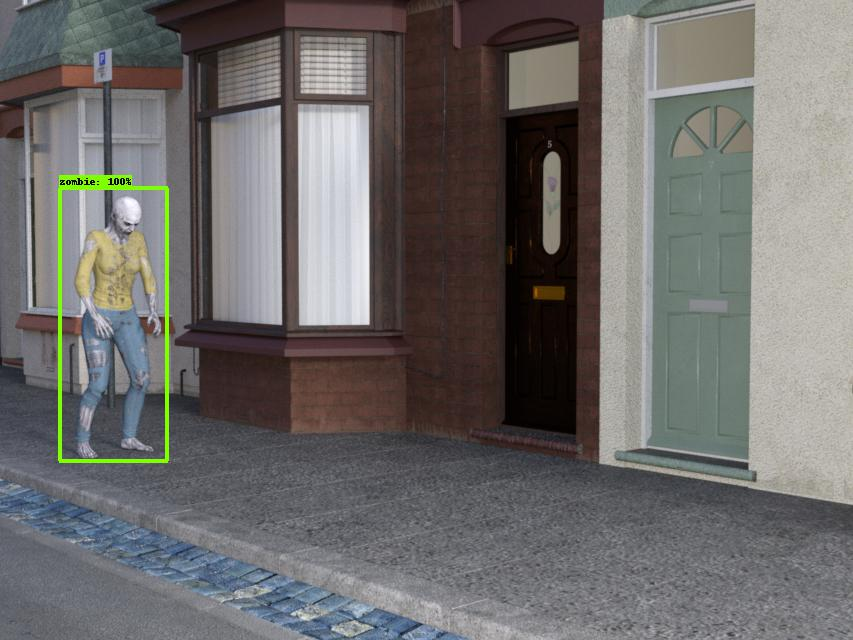

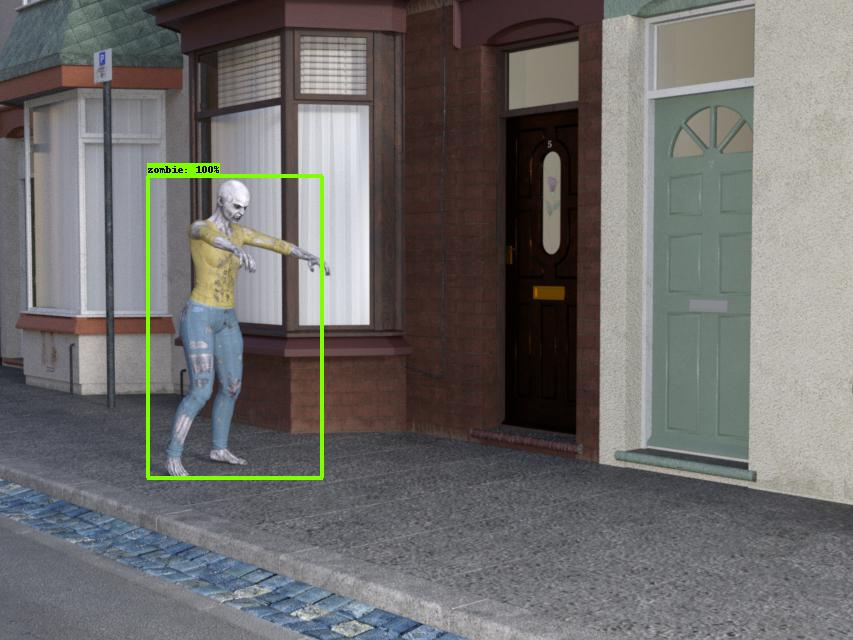

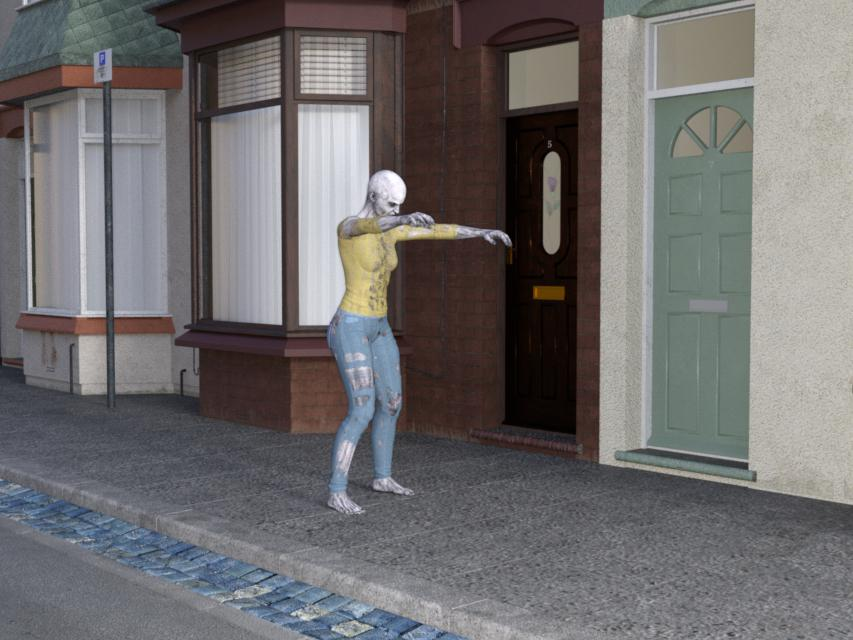

In [36]:
display(IPyImage('./results/gif_frame_000.jpg'))
display(IPyImage('./results/gif_frame_100.jpg'))
display(IPyImage('./results/gif_frame_200.jpg'))

### Create a zip of the zombie-walk images and then create Zombie animation

In [37]:
zipf = zipfile.ZipFile('./zombie.zip', 'w', zipfile.ZIP_DEFLATED)

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)

for filename in filenames:
    zipf.write(filename)

zipf.close()

In [38]:
imageio.plugins.freeimage.download()

!rm -rf ./results/zombie-anim.gif

anim_file = './zombie-anim.gif'

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=10)

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)4063232/4830080 bytes (84.1%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.
